### Feature Importance with substitution effects

feature importance를 추정하는 방법들이 substitution effect에 의해 영향을 받았는지 여부에 따라 서로 구분해 두는 것이 유용하다. 이 맥락에서는 추정된 feature importance가 다른 연관된 특성의 존재로 감소할 경우 대체 효과가 발생된다. Machine Learning에서 substitution effect란 통계학이나 계량경제학의 맥락에서 Multicollinearity라 부르는 것과 유사하다. linear substitution effect를 다루는 한 가지 방법은 original feature에 PCA를 적용한 후, 직교한 특성들에 대해 feature importance 분석을 수행하는 것이다.

#### $p-\mathrm{value}$

고전적 회귀 분석 framework는 올바른 모델 사양, 상호 상관없는 회귀 분석기 또는 백색 잡음 잔차 등, 적합화된 모델에 관한 여러가지 가정을 한다. 그러한 가정이 사실이라는 것을 전제로, 연구자들은 가설 검정을 통해 설명 변수의 중요도를 결정하고자 노력해 왔다. 변수의 중요도와 설명력을 표현하는 일반적인 방법은 1700년대에 제안된 개념인 p-value가 있다

$$p-\mathrm{value} = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}$$

p-value는 해당 변수와 관련된 실제 계수가 0일 떄 우리가 추정했던 것과 같거나 더 극단적인 결과를 얻었을 확률을 계량화한다. 이는 데이터가 설정된 통계 모형과 얼마나 일치하지 않는지를 나타낸다. 그러나, p-value는 귀무가설이나 대립가설이 참이 아니거나 데이터가 랜덤일 확률을 측정하지 않는다. 또한, p-value의 오용은 매우 광범위하게 퍼져 있을 뿐만 아니라, 지난 수십년간의 금융 연구에서의 신뢰도 문제를 불러일으킨다

실제로 p-value의 가장 큰 담점은, 그 값의 근거가 매우 강력한 가정에 의존한다는 것이다. 그러한 가정들이 하나라도 빗나갈 때, false positive와 false negative로 나타날 가능성이 높아진다. 이러한 이유 때문에, 2019년 미국 통계협회에서는 통계적 유의성의 척도로서 p-value의 적용을 권장하고 있지 않다(Wasserstein et al. 2019)

p-value의 두 번째 단점은 높은 multicollinearity를 가지고 있는 변수들에 대해서 p-value를 강건하게 추정할 수 없다는 것이다. 다중공선성이 존재하는 상황에서 전통적 회귀 분석 방법은 중복된 정보를 구별할 수 없으므로, p-value간의 대체효과가 발생해 실제 값보다 부풀려지는 결과가 나올 수 있다

p-value의 세 번째 단점은 완전히 관련이 없는 확률을 평가한다는 것이다. 귀무가설 $H_0$와 추정된 계수 $\hat{\beta}$이 주어졌을 때, p-value는 $H_0$이 참인 경우 $\hat{\beta}$과 같거나 극단적인 결과를 얻을 확률을 추정한다. 그러나, 연구자들은 종종 다른 확률, 즉 $\hat{\beta}$을 관찰했을 때 $H_0$이 참일 확률에 더 관심이 있다. 이 확률은 Bayes theorem을 이용해 계산할 수 있으며, 주변분포에 대해 가정을 해야 구할 수 있다.

p-value의 네 번째 결함은 샘플의 유의성을 평가한다는 것이다. 전체 샘플은 계수 추정과 유의성 결정이라는 두 가지 과제를 해결하는데 사용된다. 따라서, p-value는 샘플 외 설명값이 없는 변수에 대해 낮을 수 있다. 동일한 데이터셋에 대해 여러 번의 샘플 내 테스트를 진행하면 잘못된 발견을 할 가능성이 높아지며, 이는 통계적 사기이다

요약하자면, p-value는 필요 이상의 너무 많은 가정을 요구하기 때문에 변수가 여러개인 모형에는 알맞지 않으며, 유의성을 추정하기에도 적절치 않은 값이다. 아래 예를 통해 p-value가 어떻게 정보를 희석시키는지 알아보도록 한다

다음 함수는 informative, redundant, noise feature를 생성하는 함수이다. 각각의 feature는 다음과 같은 특징을 갖는다

1. informative : label 예측에 있어서 실질적으로 가장 고유하고 독립적인 정보를 제공하는 feature
2. redundant : label 예측에 있어서 중요한 정보를 제공하긴 하지만, feature간 다중공선성이 존재하는 feature
3. noise : label 예측에 있어서 거의 아무런 영향을 주지 않는 feature

In [1]:
import pandas as pd
import numpy as np

def get_test_data(
        n_features : int = 40,
        n_informative : int = 10,
        n_redundant : int = 10,
        n_samples : int = 10000,
        random_state : int = 42,
        sigma_std : float = 0.0
) : 
    from sklearn.datasets import make_classification
    
    np.random.seed(random_state)
    
    trnsX, cont = make_classification(
        n_samples = n_samples,
        n_features = n_features,
        n_informative = n_informative,
        n_redundant = n_redundant,
        random_state = random_state,
        shuffle = False
    )
    
    df0_index = pd.date_range(start = pd.to_datetime('today') - pd.to_timedelta(n_samples, unit = 'd'), 
                              periods = n_samples, freq = 'B')

    trnsX, cont = pd.DataFrame(trnsX, index = df0_index), pd.Series(cont, index=df0_index).to_frame('bin')

    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    
    trnsX.columns = df0
    cont['w'] = 1. / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index = cont.index)
    
    return trnsX, cont

전체 feature는 20개, informative는 5개, redundant feature는 5개로 지정한다. noise는 자동적으로 10개가 된다. 관측치의 수는 1000개로 generating한다

In [2]:
trnsX, cont = get_test_data(
    n_features = 20, 
    n_informative = 5, 
    n_redundant = 5, 
    n_samples = 1000
)

In [3]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

ols = sm.Logit(cont['bin'], trnsX).fit()

         Current function value: 0.438438
         Iterations: 35


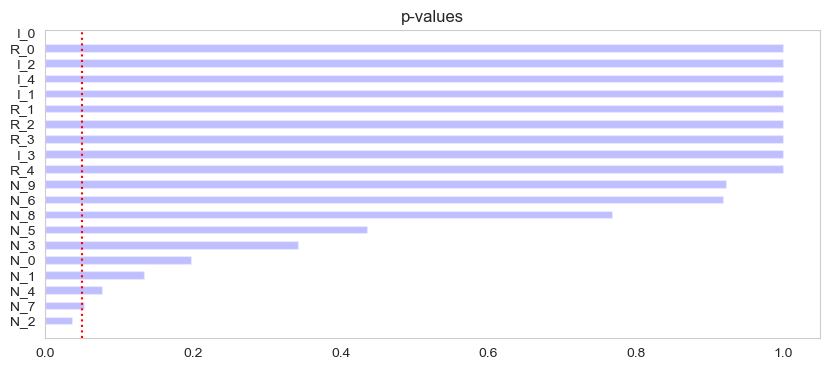

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))
plt.barh(
    ols.pvalues.sort_values(ascending = True).index, 
    ols.pvalues.sort_values(ascending = True), 
    color = 'b', alpha = 0.25, height = 0.5
)
plt.axvline(0.05, ls = ':', color = 'r')
plt.grid(False)
plt.title('p-values')
plt.show()

불행히도 금융 데이터셋은 시장, 섹터, 등급, 가치, 모멘텀, 이익의 질, 기간 등 투자 환경의 많은 부분에서 공유하는 공통 risk factor의 결과로서 고도로 multicollinearity인 경우가 많다. 이런 상황에서 금융 연구자들은 p-value에만 의존하는 것을 중단해야 한다. 금융 연구자들은 특정 현상에 어떤 변수가 정보를 담고 있는지 판단하기 위한 추가 방법을 숙지하는 것이 중요하다

#### Mean Decrease Importance

F개의 특성과 관찰당 하나의 레이블로 구성된 크기 N개의 학습 샘플을 갖고 있다고 가정하자. Tree Model을 기반으로 하는 분류/회귀 알고리즘은 각 노트 $t$에서 label을 2개의 샘플로 분할한다. 주어진 feature $X_f$에 대해 임의의 threshold $\tau$이하의 $X_f$와 연관된 노드 $t$의 label은 왼쪽 샘플에 배치하고, 나머지는 오른쪽 샘플에 배치한다. 이를 분기라고 하며, Tree를 기반으로 하는 Random Forest, XG Boost, Cat Boost등 대부분의 Ensemble Model이 이러한 분기의 과정을 거친다

각 샘플에 대해 label값의 분포의 Entropy, Gini impurity 혹은 이외의 기준을 따라서 불순도를 평가할 수 있다. 직관적으로, 샘플은 한 종류의 label만을 담았을 때 가장 순수하며, label이 균등 분포를 따를 때 가장 impurity가 높다고 할 수 있다. 분할에 의해 얻을 수 있는 정보 이득은 아래와 같이 불순도의 감소로 측정된다

$$\Delta g(t, f) = i(t) - \frac{N_t^{(0)}}{N_t}i(t^{(0)}) - \frac{N_t^{(1)}}{N_t}i(t^{(1)})$$

여기서 $i(t)$는 노드 $t$에서의 label의 불순도이고, $i(t^{(0)})$는 왼쪽으로 분기된 샘플의 불순도, $i(t^{(1)})$은 오른쪽으로 분기된 샘플의 불순도이다

각 노드 $t$에서 분류모형은 $\{X_f\}_{1, \dots, F}$의 다양한 feature에 대해 $\Delta g(t, f)$를 평가하고, 이들 각각에 대해 $\Delta g(t, f)$를 최대화하는 최적 임계값 $t$를 결정하고, 최대 $\Delta g(t, f)$와 연관된 특성을 선택한다. 분류 알고리즘은 더 이상의 Information Gain(정보 이득)이 발생하지 않거나 최대 허용 한도 미만으로 불순도를 달성하는 등의 조기 종료 조건이 충족될 때까지 샘플을 분기한다

Feature Importance는 특성이 선택된 모든 노드에서 Weighted Information Gain(가중 정보 이득)으로 계산할 수 있다. Mean Decrease Impurity는 특성이 얼마나 불순도를 줄여주는데 기여를 하는지 보여주는 지표이며, 모든 특성의 중요도의 합은 1로 계산된다. 동등한 정보를 가진 feature가 $F$개 있으면 각 feature의 중요도는 $\frac{1}{F}$일 것으로 기대된다.

MDI로 작업할 때에는 명심해야 할 몇 가지 사항이 있다.

1. tree 기반 분류기가 특정 특성을 선호해 다른 특성을 체계적으로 무시하는 일이 발생하면 mask 효과가 발생한다. 이를 극복하기 위해서는 `sklearn`의 `RandomForestClassifier`를 사용할 때 `max_features = 1`로 설정해야 한다. 이런 방식을 사용해 레벨별로 오직 하나의 랜덤 특만 고려하도록 한다.
    - 모든 feature에 대해 불순도를 줄일 수 있는 기회를 준다
    - 중요도가 0인 특성들은 평균 계산에 포함시키지 말아야 한다. 0인 유일한 이유는 특성이 랜덤으로 선택되지 않았기 때문이다. 이런 값들은 `numpy.nan`등으로 대체해야 한다.

sklearn에서 Random Forest와 같은 앙상블 모형은 다음과 같은 방법으로 MDI feature importance를 추정하는 method가 기본적으로 탑재되어 있다

```
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
```

importance 추정치는 계량경제학 모형의 beta (coefficient) 추정치와 대응되며, std는 변수의 t-distribution을 추정하는 것과 유사하다. 즉, feature importance는 하나의 parameter로 작용 가능하다

한편, 우리는 시계열 모형에 대해서 다루므로, 다음과 같이 시간적 정보의 중복을 제거한 feature importance를 사용하도록 한다

In [5]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from FinancialMachineLearning.feature_importance import *

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

In [6]:
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold, cross_val_score
cv_gen = PurgedKFold(
    n_splits = 5, 
    samples_info_sets = cont['t1']
)

In [7]:
oos_score = cross_val_score(
    forest, # base classifier
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

In [8]:
from FinancialMachineLearning.feature_importance.importance import *
mdi = mean_decrease_impurity(fit, trnsX.columns)

In [9]:
mdi.head()

,mean,std
I_0,0.109207,0.003650
I_1,0.042993,0.000928
I_2,0.044925,0.001045
I_3,0.078004,0.002632
I_4,0.055393,0.001253


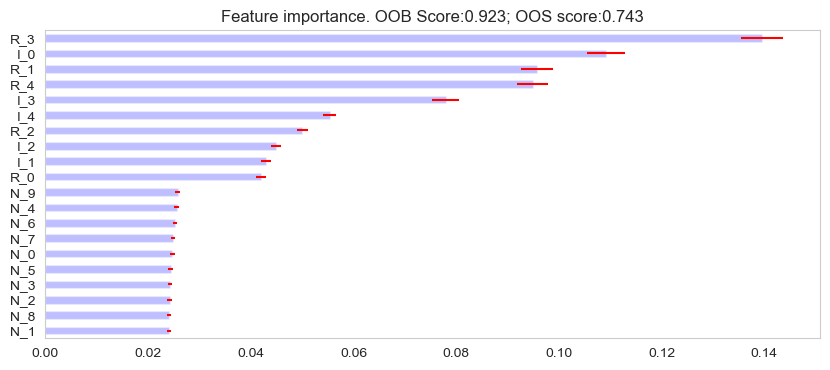

In [10]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

p-value의 결과와 비교해 봤을때, Noise가 모두 하위에 랭크된 것을 볼 수 있다. 모델 학습에 있어서 정보를 가지고 있는 information과 redundant feature들이 중요도가 높게 나온 것을 알 수 있다

MDI feature importance는 다음과 같은 장점이 존재한다

1. MDI는 계산하는 데 있어서 변수의 강력한 분포적 가정을 요구하지 않는다. 즉, 변수의 분포는 어떤 모양을 해도 상관없다
2. 통계모형의 beta는 단일 샘플에 대해 추정되는 반면, ensemble모형의 MDI feature importance는 Bootstrapping을 통해 도출된다. 따라서, 추정치의 분산은 ensemble추정기의 개수를 증가시킴으로써 줄일 수 있다
3. Base Model이 Tree인 분류기의 목적은 주어진 대수 방정식의 계수를 추정하는 것이 아니므로 특정 귀무가설의 확률을 추정하는 것과는 무관하다. 따라서, 추정기에서 실질적으로 도움이 된 특성을 찾아 점수를 매겨준다

다만, MDI는 어디까지나 sample내에서 계산된다는 점에서 과적합의 여지가 존재한다. 이후 소개하는 **MDA feature importance**는 이러한 단점을 보완해 준다

#### Mean Decrease Accuracy

p-value와 MDI 모두 설명 목적으로 샘플 내에서 유의적으로 보이는 변수가 예측의 목적과 무관할 수 있다는 점이다. 이 문제를 해결하고자, MDA 특성 중요도가 제안되었다

MDA는 다음과 같이 동작한다. 
1. 모델을 적합화시키고 교차 검증된 성과를 계산한다
2. 동일한 적합화 모델읠 교차 검증된 성과를 하는데, 단 하나의 차이점은 feature 중 하나와 관련된 관찰값들을 셔플링한다는 것이다. 그것은 특성당 하나의 수정된 교차검증 성능을 제공한다
3. 셔플링 전후의 교차 검증된 성능을 비교함으로써, 특정 feature와 연관된 MDA score를 도출한다. **특성이 중요하다면 특성이 독립인 경우, 셔플링으로 인해 성과의 현저한 저하 현성이 있어야 한다**

MDA의 중요한 속성은 MDI와 마찬가지로 단일 추정치의 결과가 아닌 여러개의 추정치의 평균이라는 것이다. 일반적으로, MDA feature importance는 **순열 중요도 (permutation importance)** 로 많이 불리며, 다음과 같이 구현된다

```
from sklearn.inspection import permutation_importance
r = permutation_importance(
    model, X_val, y_val,
    n_repeats=30,
    random_state=0
)
```

우리는 시간의 순서가 중요한 시계열 데이터를 다루고 있으므로 permutation importance를 그대로 쓰는것 보다는 아래 예제의 MDA 특성 중요도를 사용하도록 하자

한가지 중요한 점은, feature가 독립적이지 않은 경우 MDA는 상호 관련 특성의 중요성을 과소평가할 수 있다. 극단적으로, 매우 중요하지만 동일한 두가지 feature를 고려할 때, MDA는 한 가지 feature를 셔플링하는 효과가 동인한 다른 feature의 존재로 인해 상쇄될 수 있기 때문에, 두 feature모두 중요하지 않다고 결론내릴 수 있다.아래의 예시를 보고, 이러한 점을 확인해 보자

In [14]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 3,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

In [15]:
mda = mean_decrease_accuracy(
    fit, # base classification model
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

In [16]:
mda.head()

,mean,std
I_0,0.211662,0.162442
I_1,0.115781,0.043387
I_2,0.087481,0.047900
I_3,0.112996,0.045303
I_4,0.211187,0.087500


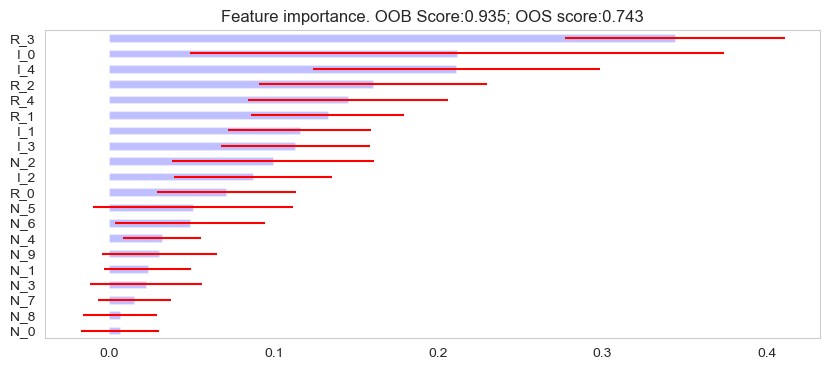

In [17]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/MDA_feature_importance.png'
)
plt.grid(False)
plt.show()